In [1]:
import numpy as np
from scipy.linalg import expm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

In [2]:
#NUMERICS AND LINEAR ALEBRA

def Advance(i_h, _Delta, _N):
    """Generates the Matrix used to advance the system using
    matrix exponentiation"""
    one_over_two_Delta = 1.0/(2.0*_Delta)
    MM = np.zeros([_N+1,_N+1],dtype = float)
    
    #Column 0
    # [0,0] = 0
    MM[1,0] = -1.0*i_h*2
    MM[2,0] = 2.0  
    
    #Column 1
    # [0,1] = 0
    MM[1,1] = -2.0*( one_over_two_Delta - 0.2 )
    MM[2,1] = -1.0*i_h*2
    MM[3,1] = 1.6  

    #Columns 2 .. N-2
    for n in range(2,_N-1):
        MM[n-2,n] = -1.0*n*(n-1)*(n-2)/float((2*n+1)*(2*n-1))
        MM[n-1,n] =   i_h*n*(n-1)/float(2*n+1)
        MM[n,  n] = -1.0*n*(n+1)*( one_over_two_Delta-1/float((2*n+3)*(2*n-1)))
        MM[n+1,n] = -1.0*i_h*(n+1)*(n+2)/float(2*n+1)
        MM[n+2,n] =        (n+1)*(n+2)*(n+3)/float((2*n+1)*(2*n+3))

    #Column N-1
    MM[_N-3,_N-1] = -1.0*(_N-1)*(_N-2)*(_N-3)/float((2*_N-1)*(2*_N-3))
    MM[_N-2,_N-1] =  i_h*(_N-1)*(_N-2)/float(2*_N-1)
    MM[_N-1,_N-1] = -1.0*(_N-1)*_N*( one_over_two_Delta-1/float((2*_N+1)*(2*_N-3)))
    MM[_N,  _N-1] = -1.0*i_h*_N*(_N+1)/float(2*_N-1)

    #Column N
    MM[_N-2,_N] = -1.0*_N*(_N-1)*(_N-2)/float((2*_N+1)*(2*_N-1))
    MM[_N-1,_N] =  	 i_h*_N*(_N-1)/float(2*_N+1)
    MM[_N,  _N] = -1.0*_N*(_N+1)*( one_over_two_Delta-1/float((2*_N+3)*(2*_N-1)))

    return MM


def Integrals_LeftHalf(_Nmax):
    """Generates a vector that is used to calculate the Error Rate"""
    Integr = np.zeros(_Nmax+1,dtype = float)
    Integr[0] = 1.0
    Integr[1] = 0.5
    sign = 1.0
    n_df = 1.0
    nm1_df = 1.0
    for n in range(3,_Nmax+1,2):
        sign   *= -1.0
        n_df   *= n
        nm1_df *= n-1
        Integr[n] = sign * n_df /( n*(n+1)*nm1_df ) 
    
    return np.multiply(2.0*np.pi,Integr) 


def NewState(_t, _i_h, _D, _OldState):
    """Generates a new state from an old state and the normalized (time, i-h, and Delta)"""
    return np.matmul( expm(np.multiply(_t, Advance( _i_h, _D, _OldState.size-1))), _OldState)

def UpdateState(_t, _Marr, _OldState):
    """Generates a new state from an old state, a normalized time, and 'Advance' matrix"""
    return np.matmul( expm(np.multiply(_t, _Marr)), _OldState)

In [3]:
# PLOTTING ROUTINES
def Setticks(axes,xticks,xticklabels, yticks,yticklabels,_fz=24):
    axes.set_xticks(xticks)
    axes.set_xticklabels(xticklabels,fontsize=_fz)
    axes.set_yticks(yticks)
    axes.set_yticklabels(yticklabels,fontsize=_fz)
    
def plot_distributions(States):
    """ Take a list of States and plot them as Distributions over theta"""

    # Number of cells used for displaying f(\theta)
    Npoints = 8000
    cosines = [ (-1 + 2*i/float(Npoints-1)) for i in range(0,Npoints)]
    Distributions = [ np.zeros(Npoints, dtype=float) for i in range(0,len(States)) ]

    from numpy.polynomial.legendre import legval
    for i,S in enumerate(States):
        Distributions[i] = legval(cosines,S)

    fig = plt.figure(figsize=(12,10))
    ax1 = fig.add_subplot(111)
    ax1.set_ylim([1e-8,1000.0])  
    ax1.set_xlim([0.0,np.pi])  
    ax1.set_ylabel(r'$\rho(\theta)$',fontsize = 28)
    ax1.set_xlabel(r'$\theta$', fontsize = 28)
    DetailedLabels = [r'$N_{\max}=25$',r'$N_{\max}=50$',r'$N_{\max}=75$',r'$N_{\max}=100$',r'$N_{\max}=125$']

    Colors1 = ['Crimson',  'Green','DodgerBlue', 'Blue','Black',  'purple', 'Gold', 'LimeGreen']
    for i,D in enumerate(Distributions):
        ax1.semilogy(np.arccos(cosines), D, color=Colors1[i%len(Colors1)], lw=2, label = DetailedLabels[i])

    Setticks(ax1,[0,np.pi/3,2*np.pi/3,np.pi],[r'$0$',r'$\pi/3$',r'$2\pi/3$',r'$\pi$'],
             [1e-8,1e-6,1e-4,1e-2,1,100],[r'$10^{-8}$',r'$10^{-6}$',r'$10^{-4}$',r'$10^{-2}$',r'$10^{0}$',r'$10^{2}$'],22)
    ax1.legend(loc='upper center',fontsize = 20)

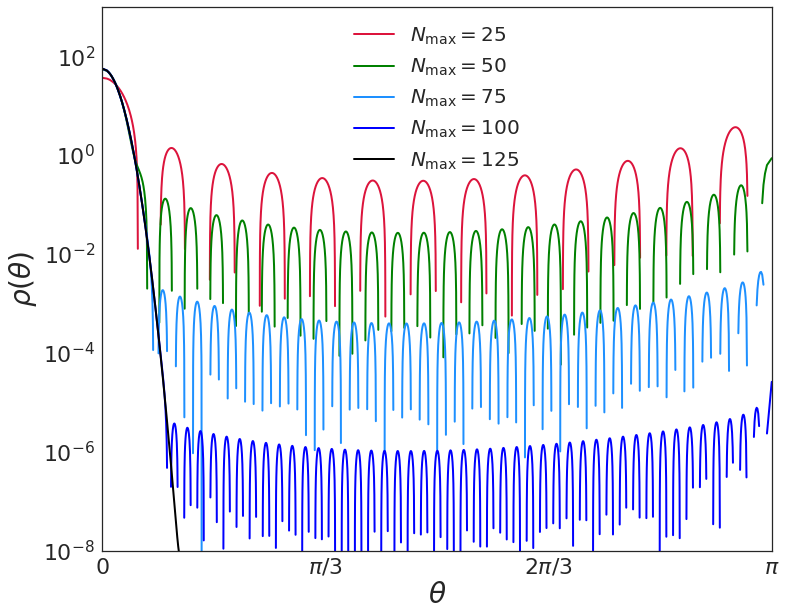

In [4]:
Delta = 60.0
Current = -2.0
Hext = 0.0
tau = 10.0

# 25
State0 = np.array([0.25/np.pi]+[0.0]*25)
State25 = NewState(tau, Current - Hext, Delta, State0)

# 50
State0 = np.array([0.25/np.pi]+[0.0]*50)
State50 = NewState(tau, Current - Hext, Delta, State0)

# 50
State0 = np.array([0.25/np.pi]+[0.0]*75)
State75 = NewState(tau, Current - Hext, Delta, State0)

# 100
State0 = np.array([0.25/np.pi]+[0.0]*100)
State100 = NewState(tau, Current - Hext, Delta, State0)

# 125
State0 = np.array([0.25/np.pi]+[0.0]*125)
State125 = NewState(tau, Current - Hext, Delta, State0)

plot_distributions([ State25,State50,State75,State100,State125])

In [75]:
# Some input parameters for Figure 2
#gam = 1.760859708e11
Delta = 60.0
Hext = 0.0

Vc0 = 0.5 #in Volt, picked for normalization
t0 = 2.0 #in ns. With t0 = (1+alpha*alpha)/(alpha*gam*Hk)*1e9, e.g. because alpha = 0.01 and Hk = 0.28398060204

Nmax = 125
Integrals = Integrals_LeftHalf(Nmax)

In [76]:
# Figure 2a
tau = 50 # = 100ns with the normalization above
J_normalized_2A = [0.3+0.01*i for i in range(0,71)]

Pns_analytical, Pns_doubleExp = [], [] 
StateInitial2A = NewState(100, 0.0, Delta, State125) # Make a relaxed state

for _J in J_normalized_2A:
    StateJ = NewState(tau,_J - Hext, Delta, StateInitial2A)    
    Pns_analytical.append( np.sum(StateJ*Integrals) )
    if (_J < 1.0):
        Pns_doubleExp.append( np.exp(-2*tau*np.exp( -Delta*(1-(_J-Hext))**2 ) ))
        
P_sw_2A = [ 1-p for p in Pns_analytical]
dExp_2A = [ 1-p for p in Pns_doubleExp ]

In [77]:
#Figure 2b
taus = [2.5,5,10,15,25,50]

State0 = np.array([0.25/np.pi]+[0.0]*Nmax)
StateA = NewState(100, -2.0 - Hext, Delta, State0)
StateB = NewState(1000, 0.0 - Hext, Delta, StateA)

J_normalized_2B = [
    (0.5+0.005*i) for i in range(0,81,4)]+[
    (0.5+0.005*i) for i in range(81,121)] + [
    (0.5+0.005*i) for i in range(121,401,5)]
    
WERs_2B = [[] for i in range(len(taus))]
for i,tau in enumerate(taus):    
    for _J in J_normalized_2B:
        StateJ = NewState(tau,_J - Hext, Delta, StateB)
        (WERs_2B[i]).append( np.sum(StateJ*Integrals) )

In [78]:
#Figure 2c

def SwitchingTime(_J, _Delta, _WERtarget, _prange,_Nmax):
    """Use the bisection method to calculate the 
    switching time for a given pulse width"""
    
    # Select the number of expansion terms
    Int = Integrals_LeftHalf(_Nmax)
    
    # Error tolerances
    Tol_taccur = 1e-3  # (t2-t1)/2 tolerance
    Tol_WER = 1e-4  # WER tolerance
    MaxIter = 40 # Maximum number of bisections
    
    # Setup initial state
    S0 = np.array([0.25/np.pi]+[0.0]*_Nmax)
    S1 = NewState(100, -2.0, _Delta, S0)
    S2 = NewState(1000, 0.0, _Delta, S1)
    
    # Pre-calculate the "Advance" array
    Marr = Advance(_J, _Delta, Nmax)
    t1, t2 = _prange[0], _prange[1]
    
    # Check if there is a solution in this range
    St2 = UpdateState(t2, Marr, S2)
    WER2 = np.sum(St2*Int)
    if  ( (WER2 - _WERtarget) > 0 ):
        return 1e+20
    
    # Run bisection up to MaxIter times
    for i in range(0,MaxIter):    
        tmid = 0.5*(t2+t1)
        Smid = UpdateState(tmid, Marr,S2)
        WER =  np.sum(Smid*Int)
        if ( np.abs(WER - _WERtarget) < Tol_WER*_WERtarget ):
            return tmid
        if ( np.abs(t2-t1) < 2.0*Tol_taccur*t1 ):
            return t2
        if (WER < _WERtarget):
            t2 = tmid
        else:
            t1 = tmid
    
    return tmid

def Tswitch(V,Delta,_Nmax,_WER=0.5):
    y = np.zeros(len(V))
    time_range = [0.0,1e+5]
    indices = sorted(range(len(V)), key=lambda k: V[k],reverse=True)
    for i in indices:
        y[i] = SwitchingTime(V[i],Delta,_WER,time_range,_Nmax)
        time_range=[y[i],10.0*y[i]]
    return y

In [79]:
Vvals = np.linspace(0.3,1,30)
Vvals_normalized = np.multiply(1.0/Vc0,Vvals)
WERts = [0.5,0.1,0.001,1e-5,1e-7]
tswitches = []
for wert in WERts:
    tswitches.append(Tswitch(Vvals_normalized,Delta,Nmax,wert))
    print "Tswitch with WER = "+str(wert)+" finished."

Tswitch with WER = 0.5 finished.
Tswitch with WER = 0.1 finished.
Tswitch with WER = 0.001 finished.
Tswitch with WER = 1e-05 finished.
Tswitch with WER = 1e-07 finished.


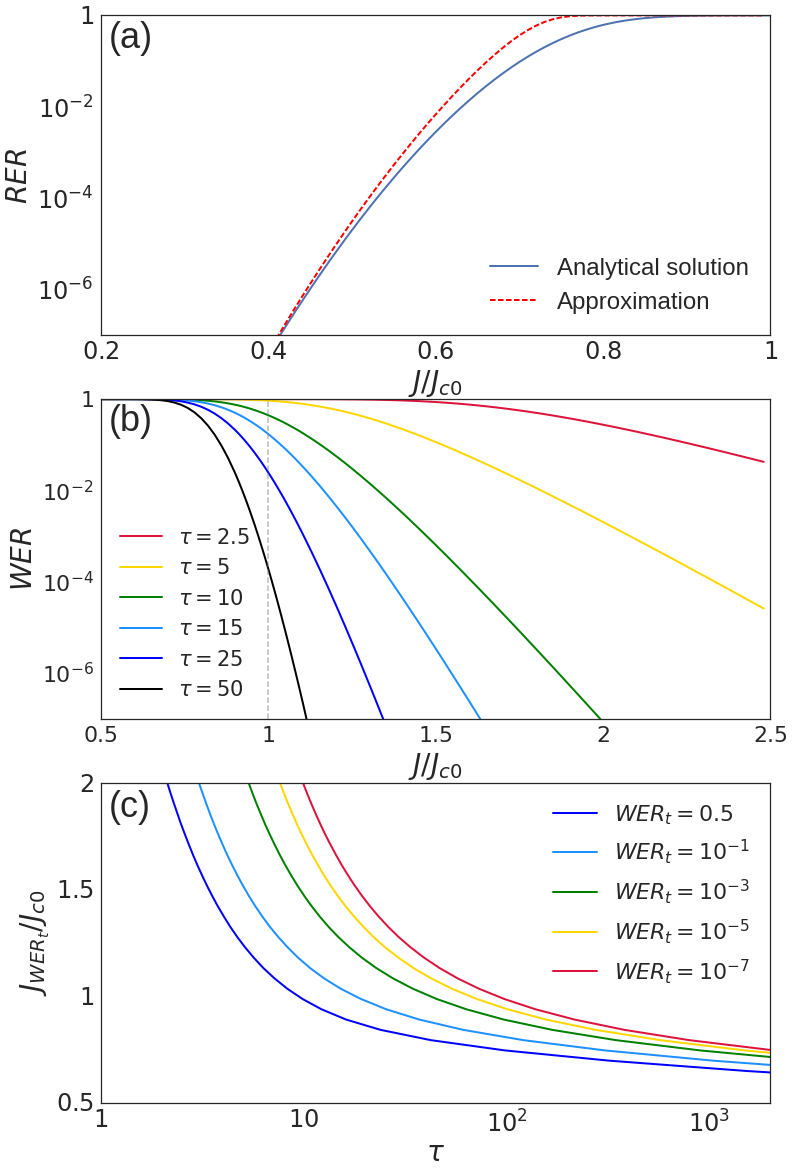

In [80]:
# Plot
fig_second = plt.figure(figsize=(12,20))

# Figure 2a
ax2_a = fig_second.add_subplot(311)
ax2_a.semilogy(J_normalized_2A, P_sw_2A, label = 'Analytical solution',lw = 2)
ax2_a.semilogy(J_normalized_2A[0:len(dExp_2A)], dExp_2A, label = 'Approximation', color = 'r',lw =2,ls = 'dashed')

ax2_a.set_xlim([0.2,1.0])  
ax2_a.set_ylim([1e-7,1])  
ax2_a.set_ylabel('$RER$', fontsize = 28)
ax2_a.set_xlabel('$J/J_{c0}$', fontsize = 28)
ax2_a.legend(loc='lower right',fontsize = 24)
ax2_a.annotate('(a)', xy=(0.21,0.2), fontsize = 36)#34
Setticks(ax2_a,[0.2,0.4,0.6,0.8,1.0], [r'$0.2$',r'$0.4$',r'$0.6$',r'$0.8$',r'$1$'] ,
                  [1e-6,1e-4,1e-2,1], [r'$10^{-6}$',r'$10^{-4}$', r'$10^{-2}$',r'$1$'])

#Figure 2b
ax2_b = fig_second.add_subplot(312)
Colors2B = ['Crimson', 'Gold',  'Green','DodgerBlue', 'Blue','Black',  'purple', 'LimeGreen']
times = [r'$\tau=2.5$',r'$\tau=5$',r'$\tau=10$',r'$\tau=15$',r'$\tau=25$',r'$\tau=50$']
for i in range(0,len(WERs_2B)):
    ax2_b.semilogy(J_normalized_2B,WERs_2B[i],color=Colors2B[i], lw=2, ls = '-', label = times[i])

ax2_b.set_ylim([1e-7,1])  
ax2_b.set_xlim([0.5,2.5])  
ax2_b.set_ylabel(r'$WER$',fontsize = 28)
ax2_b.set_xlabel(r'$J/J_{c0}$', fontsize = 28)
ax2_b.axvline(x=1, color = "Gray",lw = 2, ls = 'dashed',alpha=0.4)
ax2_b.legend(loc='lower left',fontsize = 21)
ax2_b.annotate('(b)', xy=(0.525,0.2), fontsize = 36)
Setticks(ax2_b,[0.5,1.0,1.5,2.0,2.5],[r'$0.5$',r'$1$',r'$1.5$',r'$2$',r'$2.5$'] ,
               [1e-6,1e-4,1e-2,1],[r'$10^{-6}$', r'$10^{-4}$', r'$10^{-2}$',r'$1$'], 22)

# Figure 2c
ax2_c = fig_second.add_subplot(313)
Colors2C = ['Blue','DodgerBlue','Green','Gold','Crimson']
Labels2C = [r'$WER_t=0.5$',r'$WER_t=10^{-1}$',r'$WER_t=10^{-3}$',r'$WER_t=10^{-5}$',r'$WER_t=10^{-7}$']
for tsw,cl,lbl in zip(tswitches,Colors2C,Labels2C):
    ax2_c.plot(tsw,Vvals_normalized,color=cl,lw=2,ls='-',label=lbl)

ax2_c.set_xscale('log',fontsize = 18)
ax2_c.set_xlim([1,2e+3])
ax2_c.set_ylim([0.5,2.0])
ax2_c.set_xlabel(r'$\tau$',fontsize = 28)
ax2_c.set_ylabel(r'$J_{WER_t}/J_{c0}$',fontsize = 28)
ax2_c.legend(loc='upper right',fontsize = 22)
ax2_c.annotate('(c)', xy=(1.1,1.84), fontsize = 36)#34
Setticks(ax2_c,[1.,10.,100.,1000.],[r'$1$', r'$10$', r'$10^2$', r'$10^3$'] ,
               [0.5,1,1.5,2],[r'$0.5$', r'$1$',  r'$1.5$',r'$2$'])